In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

Files:
- metadata: Each row represents the metadata for one unique flight
- waypoints: Each row contains data from one recorded ADS-B waypoint provided at 40-second intervals
- uk-waypoints: Each row contains data from one recorded ADS-B waypoint provided at 1-second intervals

In [9]:
# Scrape all RyanAir flights during the week
metadata_daily = []
wypts_daily = []

for i, day in enumerate(range(1,8)) : 

    print(f'{i+1}/7 Fetching 0{day} July 2021 data ... ')
    clear_output(wait = True)

    df = pd.read_parquet(f'2021-07-0{day}-metadata.pq')
    df.insert(2, 'company', df['flight_number'].apply(lambda x: x[:2]))
    df = df.groupby('company').get_group('FR')
    metadata_daily.append(df)

    df = pd.read_parquet(f'2021-07-0{day}-waypoints.pq')
    df.insert(2, 'company', df['flight_number'].apply(lambda x: x[:2]))
    df = df.groupby('company').get_group('FR')
    wypts_daily.append(df)

metadata = pd.concat(metadata_daily).reset_index(drop = True)
waypoints = pd.concat(wypts_daily).reset_index(drop = True)

del metadata_daily, wypts_daily, df

print('Metadata :', metadata.shape)
print('Waypoints :', waypoints.shape)

Metadata : (12475, 45)
Waypoints : (1973506, 11)


In [10]:
metadata

,flight_id,callsign,company,icao_address,flight_number,tail_number,aircraft_type_icao,aircraft_engine_type,origin_airport,origin_airport_name,origin_country,destination_airport,destination_airport_name,destination_country,scheduled_departure_time_utc,scheduled_arrival_time_utc,first_waypoint_time,last_waypoint_time,duration_hours,total_distance_km,great_circle_distance_km,longitude_first_waypoint,longitude_last_waypoint,longitude_min,longitude_max,latitude_first_waypoint,latitude_last_waypoint,latitude_min,latitude_max,altitude_first_waypoint,altitude_last_waypoint,altitude_min,altitude_max,n_wypts,n_terrestrial,n_satellites,n_interpolate,n_extrapolate,n_great_circle,extrap_trajectory_start,extrap_trajectory_end,trajectory_complete,great_circle_trajectory,est_origin_airport,est_destination_airport
0,210701-1457-RYR17,RYR17,FR,4CA64F,FR3335,EI-DYM,B738,Jet,LFBO,Toulouse-Blagnac Airport,FR,LPPR,Francisco de Sá Carneiro Airport,PT,NaT,NaT,2021-07-01 00:14:10.395,2021-07-01 01:37:54.000,1.40,887.16,865.177286,1.363820,-8.681390,-8.71,1.36,43.629101,41.248100,41.25,43.66,499.0,228.0,228.0,41000.0,117,17,0,96,4,0,True,True,True,False,True,True
1,210701-28842-RYR7BJ,RYR7BJ,FR,4CA8D8,FR3340,EI-ENM,B738,Jet,LCPH,Paphos International Airport,CY,EETN,Lennart Meri Tallinn Airport,EE,2021-07-01 02:50:00,2021-07-01 07:05:00,2021-07-01 02:50:07.149,2021-07-01 06:45:45.063,3.93,3012.52,2802.361806,32.485699,24.832800,22.98,32.49,34.717999,59.413300,34.72,59.42,41.0,131.0,41.0,39000.0,333,47,0,284,2,0,True,True,True,False,False,False
2,210701-1474-RYR7489,RYR7489,FR,4CA912,FR7489,EI-EPD,B738,Jet,LGRP,Diagoras Airport,GR,LRSV,Suceava Stefan cel Mare Airport,RO,2021-07-01 03:00:00,2021-07-01 05:10:00,2021-07-01 03:17:46.000,2021-07-01 05:04:38.000,1.78,1370.14,1262.594060,28.086201,26.354099,26.35,29.14,36.405399,47.687500,36.41,47.69,17.0,1375.0,17.0,38000.0,149,21,0,121,7,0,True,True,True,False,False,False
3,210701-1520-RYR586E,RYR586E,FR,4D2220,FR3334,9H-QBM,B738,Jet,LROP,Henri Coandă International Airport,RO,LCPH,Paphos International Airport,CY,2021-07-01 03:15:00,2021-07-01 05:15:00,2021-07-01 03:24:36.056,2021-07-01 05:13:18.000,1.81,1303.61,1224.105733,26.085000,32.485699,26.08,32.69,44.571111,34.717999,34.65,44.57,314.0,41.0,41.0,37000.0,153,22,0,126,5,0,True,True,True,False,False,False
4,210701-1180-RYR7621,RYR7621,FR,48C121,FR7621,SP-RKB,B738,Jet,EYKA,Kaunas International Airport,LT,EKCH,Copenhagen Kastrup Airport,DK,2021-07-01 03:25:00,2021-07-01 04:50:00,2021-07-01 03:28:55.000,2021-07-01 04:40:40.728,1.20,787.52,726.455682,24.084801,12.656000,12.43,24.14,54.963902,55.617901,54.96,55.62,256.0,17.0,17.0,40000.0,103,14,0,86,3,0,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470,210707-43511-RYR4HT,RYR4HT,FR,4CA80E,FR7210,EI-EKN,B738,Jet,LEIB,Ibiza Airport,ES,LEVC,Valencia Airport,ES,2021-07-07 21:35:00,2021-07-07 22:20:00,2021-07-07 21:35:41.994,2021-07-07 22:00:11.127,0.41,178.14,173.941318,1.373120,-0.481625,-0.49,1.37,38.872898,39.489300,38.86,39.49,24.0,240.0,24.0,14775.0,36,6,0,28,2,0,True,True,True,False,False,False
12471,210707-43233-RYR85NX,RYR85NX,FR,4CA4F0,FR271,EI-DPL,B738,Jet,EGSS,London Stansted Airport,GB,EIDW,Dublin Airport,IE,2021-07-07 21:45:00,2021-07-07 22:59:00,2021-07-07 21:44:44.464,2021-07-07 22:35:28.120,0.85,487.04,470.683054,0.235000,-6.270070,-6.27,0.25,51.884998,53.421299,51.88,53.42,348.0,242.0,242.0,36000.0,73,11,0,60,2,0,True,True,True,False,False,False
12472,210707-43279-RYR3GU,RYR3GU,FR,4CA571,FR298,EI-DWL,B738,Jet,EIDW,Dublin Airport,IE,EGSS,London Stansted Airport,GB,2021-07-07 21:45:00,2021-07-07 22:59:00,2021-07-07 21:45:00.000,2021-07-07 22:30:06.000,0.75,492.17,476.214310,-6.276646,0.302438,-6.28,0.30,53.502274,51.929952,51.93,53.50,17375.0,1200.0,1200.0,35000.0,64,10,0,54,0,0,False,True,False,False,False,False
12473,210707-9508

# Trajectory plots

In [224]:
def flight_map(start, end, save = False) :   

    metadata_period = metadata[(metadata['first_waypoint_time'] > start) & (metadata['last_waypoint_time'] < end)]
    print(metadata_period.shape)
   
    # From GeoPandas, our world map data
    worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    # Creating axes and plotting world map
    fig, ax = plt.subplots(figsize = (18, 10))
    worldmap.plot(color = '#0a075c', ax = ax, )

    waypoints_id = waypoints.groupby('flight_id')
    for i, id in enumerate(metadata_period['flight_id']) :
        
        print(str(round(100*(i+1)/len(metadata_period), 2)) + '% ...')

        df = waypoints_id.get_group(id).reset_index(drop = True)
        df = pd.concat([df.head(10), df.iloc[np.arange(11, len(df)-10, 10)], df.tail(10)])
        
        plt.plot(df['longitude'], df['latitude'], color = 'greenyellow', alpha = 0.1, linewidth = 0.25)
        clear_output(wait = True)

    ### FIGURE FORMATTING ###
    plt.annotate('RyanAir flights', xy = (-29, 60), fontname = 'Times', color = '#ffffce', size = 50)
    plt.annotate(start.strftime('%d.%m.%y, %H:%M') + ' - ' + end.strftime('%d.%m.%y, %H:%M'), xy = (-29, 58), fontname = 'Times', color = '#ffffce', size = 18)
   # wypts = waypoints[waypoints['flight_id'].isin(metadata_period['flight_id'])]
   # plt.xlim([wypts.longitude.min() - 5, wypts.longitude.max() + 5])
   # plt.ylim([wypts.latitude.min() - 5, wypts.latitude.max() + 5])
    plt.xlim([-30, 37.5])
    plt.ylim([25, 65])
    plt.xticks([]), plt.yticks([])
    ax.set_facecolor('#121212')
    if save:
        plt.savefig('ryanair_weekly_map.jpeg', dpi = 300)
        

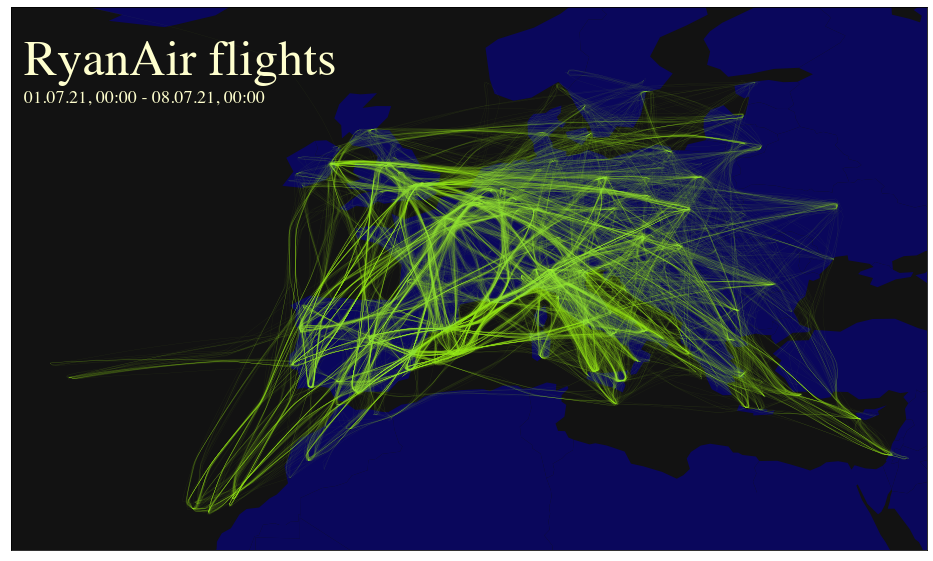

In [225]:
flight_map(datetime.datetime(2021,7,1,0,0), datetime.datetime(2021,7,8,0,0), save = False)

In [21]:
def flight_map_tail(tail_no, save = False) :   
   
    # From GeoPandas, our world map data
    worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    # Creating axes and plotting world map
    fig, ax = plt.subplots(figsize = (18, 10))
    worldmap.plot(color = '#0a075c', ax = ax, )

    plane_flights = metadata.groupby('tail_number').get_group(tail_no)
    waypoints_id = waypoints.groupby('flight_id')

    for i, id in enumerate(plane_flights['flight_id']) :
        
        print(str(round(100*(i+1)/len(plane_flights), 2)) + '% ...')

        df = waypoints_id.get_group(id).reset_index(drop = True)
        df = pd.concat([df.head(10), df.iloc[np.arange(11, len(df)-10, 10)], df.tail(10)])
        
        plt.plot(df['longitude'], df['latitude'], color = 'greenyellow', alpha = 0.5, linewidth = 0.8)
        clear_output(wait = True)

    ### FIGURE FORMATTING ###
   # plt.annotate('RyanAir flights', xy = (-29, 60), fontname = 'Times', color = '#ffffce', size = 50)
   # plt.annotate(start.strftime('%d.%m.%y, %H:%M') + ' - ' + end.strftime('%d.%m.%y, %H:%M'), xy = (-29, 58), fontname = 'Times', color = '#ffffce', size = 18)
    wypts = waypoints[waypoints['flight_id'].isin(plane_flights['flight_id'])]
    plt.xlim([wypts.longitude.min() - 5, wypts.longitude.max() + 5])
    plt.ylim([wypts.latitude.min() - 5, wypts.latitude.max() + 5])
   # plt.xlim([-30, 37.5])
   ## plt.ylim([25, 65])
    plt.xticks([]), plt.yticks([])
    ax.set_facecolor('#121212')
    if save:
        plt.savefig('ryanair_weekly_map.jpeg', dpi = 300)

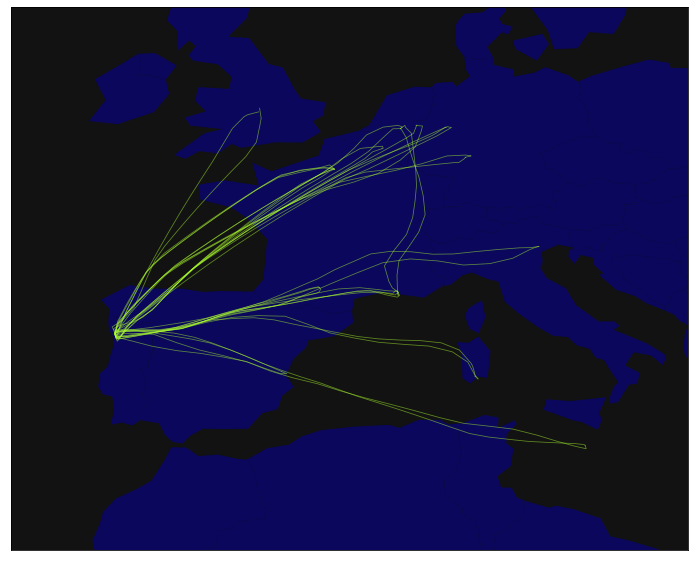

In [22]:
flight_map_tail('EI-DYM', save = False)

# Emissions model

In [6]:
metadata.aircraft_type_icao.value_counts()

B738    12004
A320      451
B38M       15
B737        4
E55P        1
Name: aircraft_type_icao, dtype: int64

In [3]:
def mode_times(metadata, begin , end) :

    metadata = metadata[(metadata['first_waypoint_time'] >= begin) & (metadata['last_waypoint_time'] < end)]

    t_climb, t_descent = [], []

    for i, id in enumerate(metadata['flight_id'], start = 1) :

        print(f'{i}/{len(metadata)} ...')
        clear_output(wait = True)

        wypts = waypoints.groupby('flight_id').get_group(id)

        threshold = 10
        flag_climb, flag_descent = True, True
        for i in range(2, len(wypts.time)-2):

            if (wypts.altitude_ft.iloc[i-1] < wypts.altitude_ft.iloc[i]) and abs(wypts.altitude_ft.iloc[i] - wypts.altitude_ft.iloc[i+1]) < threshold and abs(wypts.altitude_ft.iloc[i+1] - wypts.altitude_ft.iloc[i+2]) < threshold and flag_climb is True:
                t_climb.append(wypts.time.iloc[i])
                flag_climb = False

            if (wypts.altitude_ft.iloc[i+1] < wypts.altitude_ft.iloc[i]) and abs(wypts.altitude_ft.iloc[i] - wypts.altitude_ft.iloc[i-1]) < threshold and abs(wypts.altitude_ft.iloc[i-1] - wypts.altitude_ft.iloc[i-2]) < threshold and flag_descent is True:
                t_descent.append(wypts.time.iloc[i])
                flag_descent = False

        
        if flag_descent is True:
            t_descent.append(np.nan)

        if flag_climb is True:
            t_climb.append(np.nan)


    metadata['t_climb'] = t_climb
    metadata['t_descent'] = t_descent

    metadata['CLIMB_TIME'] = [(t_climb - first).total_seconds() / 60.0 for t_climb, first in zip(metadata.t_climb, metadata.first_waypoint_time)]
    metadata['CRUISE_TIME'] = [(t_descent - t_climb).total_seconds() / 60.0 for t_descent, t_climb in zip(metadata.t_descent, metadata.t_climb)]
    metadata['DESCENT_TIME'] = [(last - t_descent).total_seconds() / 60.0 for last, t_descent in zip(metadata.last_waypoint_time, metadata.t_descent)]

    metadata['CRUISE_TIME_norm'] = metadata.CRUISE_TIME / (metadata.duration_hours * 60)

    return metadata

In [20]:
metadata_07 = mode_times(metadata, datetime(2021, 7, 7), datetime(2021, 7, 8))

1631/1631 ...


In [23]:
def altitude_plot(id) :

    flight = metadata.groupby('flight_id').get_group(id)
    tc = flight.t_climb.iloc[0]
    td = flight.t_descent.iloc[0]

    wypts = waypoints.groupby('flight_id').get_group(id)

    climb = wypts[wypts['time'] < tc]
    cruise = wypts[(wypts['time'] >= tc) & (wypts['time'] <= td)]
    descent = wypts[wypts['time'] > td]

    plt.scatter(climb.time, climb.altitude_ft, c = 'red')
    plt.scatter(cruise.time, cruise.altitude_ft, c = 'blue')
    plt.scatter(descent.time, descent.altitude_ft, c = 'green')

In [22]:
metadata_07.to_csv('metadata_07.csv', index = False)

In [23]:
dfs = []
for i in range(1, 8):
    print(i)
    dfs.append(pd.read_csv(f'metadata_0{i}.csv'))


df = pd.concat(dfs)

1
2
3
4
5
6
7


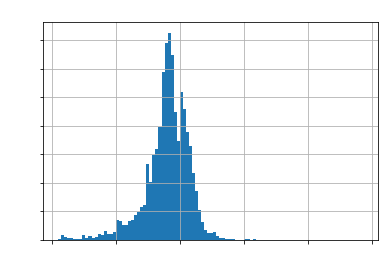

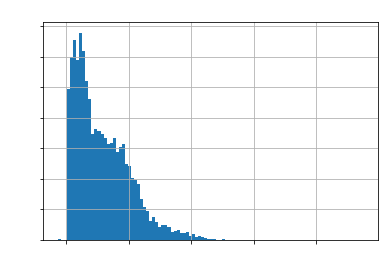

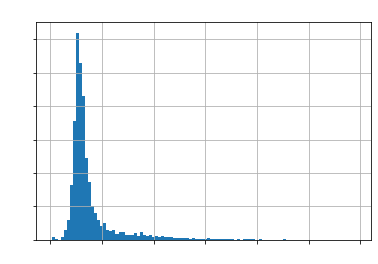

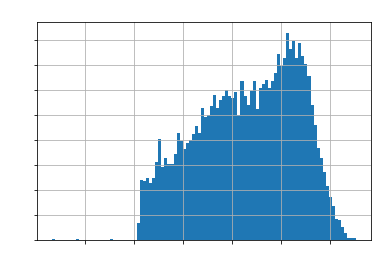

In [28]:
for f in list(df)[-4:] :

    plt.figure()
    df[f].hist(bins = 100, density = True)
    plt.xticks(color = 'white'); plt.yticks(color = 'white')
    plt.title(f, color = 'white')

In [29]:
m_dot = {'B738' : {7: 0.1, 30: 0.274, 85: 0.761, 100: 0.913},
         'A320' : {7: 0.102, 30: 0.316, 85: 0.939, 100: 1.142},
         'B38M' : {7: 0.095, 30: 0.266, 85: 0.818, 100: 1.002},
         'B737' : {7: 0.116, 30: 0.349, 85: 1.043, 100: 1.284},
         'E55P' : {7: 0.024, 30: 0.067, 85: 0.173, 100: 0.205}}

In [30]:
df['CO2_CLIMB'] = [m_dot.get(airtype).get(85) * 2 * (t * 60) * 3.15 for airtype, t in zip(df['aircraft_type_icao'], df['CLIMB_TIME'])]
df['CO2_DESCENT'] = [m_dot.get(airtype).get(30) * 2 * (t * 60) * 3.15 for airtype, t in zip(df['aircraft_type_icao'], df['DESCENT_TIME'])]
df['CO2_CRUISE'] = [m_dot.get(airtype).get(30) * 2 * (t * 60) * 3.15 for airtype, t in zip(df['aircraft_type_icao'], df['CRUISE_TIME'])]
df['CO2'] = df['CO2_CRUISE'] + df['CO2_CLIMB'] + df['CO2_DESCENT']
df['CO2_hour'] = df['CO2'] / df['duration_hours']
df['CO2_km'] = df['CO2'] / df['total_distance_km']

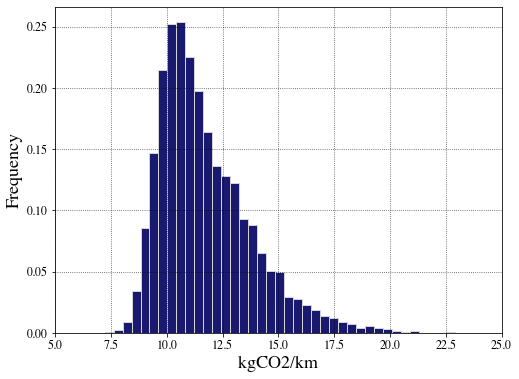

In [54]:
plt.figure(figsize = (8, 6))
plt.hist(df.CO2_km, bins = 100, density = True, color = 'midnightblue', edgecolor = 'lightgray')

plt.grid(alpha = 0.75, color = 'black', linestyle = ':')
plt.xticks(fontname = 'Times', size = 12)
plt.xlabel('kgCO2/km', fontname = 'Times', size = 18)
plt.yticks(fontname = 'Times', size = 12)
plt.ylabel('Frequency', fontname = 'Times', size = 18)
plt.xlim([5, 25])

plt.savefig('emissions_km_ryanair.jpeg', dpi = 400)
plt.show()

In [56]:
df.CO2_km.mean()

11.755250325399018

In [42]:
os, ds, freq, lens, hrs = [], [], [], [], []
for o in set(metadata['origin_airport']): 
    for d in set(metadata['destination_airport']):

        if len(o) > 0 and len(d) > 0 :

            df = metadata[(metadata['origin_airport'] == o) & (metadata['destination_airport'] == d)]


            freq.append(len(df))
            os.append(o)
            ds.append(d)
            lens.append(df.total_distance_km.mean())
            hrs.append(df.duration_hours.mean())

In [43]:
dict_names_o = dict(zip(metadata.origin_airport, metadata.origin_airport_name))
dict_names_d = dict(zip(metadata.destination_airport, metadata.destination_airport_name))

pairs = pd.DataFrame(zip(os, ds, freq, lens, hrs), columns = ['Origin', 'Destination', 'Frequency', 'Distance', 'Duration'])

pairs['Origin_name'] = [dict_names_o.get(o) for o in pairs.Origin]
pairs['Destination_name'] = [dict_names_d.get(d) for d in pairs.Destination]

In [44]:
pairs.sort_values('Frequency', ascending = False).head(25)

,Origin,Destination,Frequency,Distance,Duration,Origin_name,Destination_name
17225,LIRF,LICC,43,573.449070,0.862326,Rome–Fiumicino Leonardo da Vinci International...,Catania-Fontanarossa Airport
5240,LICC,LIRF,42,617.170476,1.011667,Catania-Fontanarossa Airport,Rome–Fiumicino Leonardo da Vinci International...
17245,LIRF,LICJ,28,435.750714,0.692500,Rome–Fiumicino Leonardo da Vinci International...,Falcone–Borsellino Airport
5264,LICC,LIMC,27,1098.933333,1.633333,Catania-Fontanarossa Airport,Malpensa International Airport
9540,LICJ,LIRF,27,472.884815,0.825556,Falcone–Borsellino Airport,Rome–Fiumicino Leonardo da Vinci International...
22600,LIMC,LICC,27,1097.354074,1.467407,Malpensa International Airport,Catania-Fontanarossa Airport
26537,LEPA,EDDK,24,1455.553333,1.965833,Palma de Mallorca Airport,Cologne Bonn Airport
20118,EDDK,LEPA,24,1441.442500,2.040417,Cologne Bonn Airport,Palma de Mallorca Airport
25929,LIBD,LIME,24,784.447917,1.225417,Bari Karol Wojtyła Airport,Milan Bergamo Airport
27765,LIME,LIBR,24,904.055417,1.178333,Milan Bergamo Airport,Brindisi Airport


<AxesSubplot:>

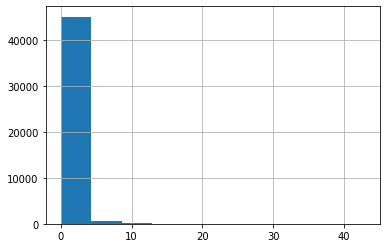